This notebook is meant for the CLUSTER version of analysis, for the purposes of creating an entropy profile that mimics the Phoenix cluster and similar clusters that lack an AGN that heats against the cooling flow.

In [29]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
# from lab_functions_1 import Ax, vcgrab, Tc, Lambdacalc, dLdTfunc, dVcdrfunc
import lab_functions_1 as lf
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.6
gamma = 5/3
ktc = 3.0857e21
etkv = 6.2415*10**8

In [30]:
from scipy.integrate import cumulative_trapezoid
ktc = 3.0857e21
r_grid = np.linspace(ktc, 1000000 * ktc, 1000000)  # finer grid = better accuracy
vc2_over_r = np.array([(lf.vcgrab(r, 485 * ktc, 1620 * ktc, 1.5e12, 1e15)**2 / r) for r in r_grid])

phi_cumint = cumulative_trapezoid(vc2_over_r, r_grid, initial=0.0)

phi_values = -(phi_cumint[-1] - phi_cumint)

phi_interp = interp1d(r_grid, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)

C:\Users\Jacob\AppData\Local\Temp\ipykernel_11796\120925839.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


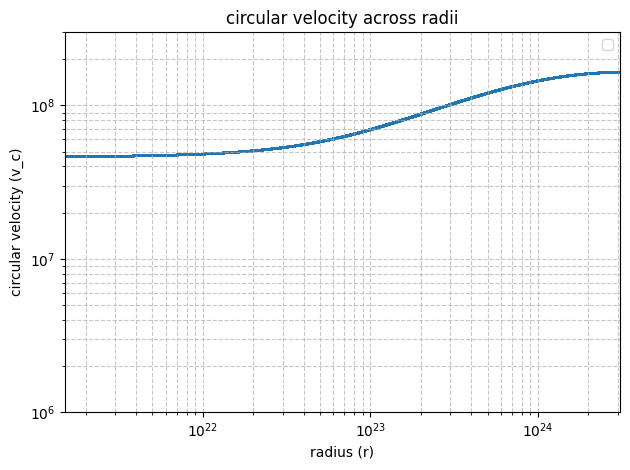

In [31]:
r_gridvc = np.logspace(np.log10(ktc/2), np.log10(1e25), 10000)  # finer grid = better accuracy
v_c = np.array([lf.vcgrab(r, 485 * ktc, 1620 * ktc, 1.5e12, 1e15) for r in r_gridvc])

plt.scatter(r_gridvc, v_c, s=1)
plt.xlabel('radius (r)')
plt.xlim(1.5e21, 3.086e24)
plt.xscale('log')
plt.ylabel('circular velocity (v_c)')
plt.ylim(1e6, 3e8)
plt.yscale('log')
plt.title('circular velocity across radii')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
def Rsonfinder(tol, r_high, r_low, x, max_iter=10000):
    iter_count = 0
    target = 1.89e28
    delta = tol * 1e27

    while r_high - r_low > tol:
        if iter_count > max_iter:
            print("Max iterations reached without convergence.")
            return None, None

        r = 0.5 * (r_high + r_low)
        #print(f"Trying r = {r:.5e}")

        cs2_sonic = lf.vcgrab(r, 485 * ktc, 1620 * ktc, 1.5e12, 1e15)**2 / (2 * x)
        v_sonic = cs2_sonic**0.5
        T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
        tflow_to_tcool = (10/3)*(1 - x)
        #print(r)
        rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, r)
        Mdot = 4 * np.pi * r**2 * rho_sonic * v_sonic
        #print(Mdot)

        if Mdot > target + delta:
            #print(f"Mdot = {Mdot:.2e} too high, decreasing r")
            r_high = r
        elif Mdot < target - delta:
            #print(f"Mdot = {Mdot:.2e} too low, increasing r")
            r_low = r
        else:
            #print(f"r = {r/ktc}")
            return r, Mdot

        iter_count += 1

    print("Did not converge within tolerance.")
    return None, None

print(Rsonfinder(1e-8, ktc*25, ktc, 0.364))

# rsongrid = np.linspace(0.25, 0.75, 500)
# rsonval = np.array([Rsonfinder(1e-10, ktc*100, ktc, x) for x in rsongrid])
# rvals = np.array([res[0] if res[0] is not None else np.nan for res in rsonval])

# plt.scatter(rsongrid, rvals, s=1, label="Sonic radius")
# plt.xlabel('x value (v_c^2 / c_s^2)')
# #plt.xscale('log')
# plt.xlim(0.25, .75)
# plt.yscale('log')
# plt.ylim(ktc, ktc*12)
# plt.ylabel('Sonic Radius (cm)')
# plt.title('Sonic Radius vs. x')
# plt.grid(True, which='both', linestyle='--', alpha=0.7)
# plt.legend()
# plt.tight_layout()
# plt.show()

(9.68020085302107e+21, np.float64(1.8900000005394952e+28))


In [33]:
def dlnTdlnrcalc(R_sonic, x, T_sonic_point,pr=True): 
 
    dlnLambda_dlnT = lf.Lambdacalc(T_sonic_point, R_sonic)
    dlnvc_dlnR = lf.dVcdrfunc(R_sonic, 485*ktc, 1620*ktc, 1.5e12, 1e15)
    
    #solve quadratic equation    
    b = 29/6.*x - 17/6. + 1/3.*(1.-x)*(dlnLambda_dlnT)
    c = 2/3.*x*dlnvc_dlnR + 5*x**2 - 13/3.*x + 2/3.
    if b**2-4*c >= 0:
        return [(-b +j * (b**2-4*c)**0.5)/2. for j in (-1,1)]
    else:
        if pr: print('no transsonic solutions')
        return None, None

In [68]:
# THE ODE SOLVER ITSELF
def TheODE(r, C, Mdot):
    v, T = C
    #T = np.clip(T, 1.585e4, 1.445e8)
    
    vc2 = lf.vcgrab(r, 485*ktc, 1620*ktc, 1.5e12, 1e15)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)
    
    Lambda = lf.Lambdacalc(T, r)
    #print(Lambda)
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow/ (gamma*tcool))) / (mach**2 - 1.0)
    dlnTdlnr = (tflow / tcool) - (2/3) * (2 + dlnvdlnr)
    
    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr

    if r % ktc < ktc*0.005:
        print(f"r = {r}, dlnvdlnr = {dlnvdlnr}, dlnTdlnr = {dlnTdlnr}, vc_csa = {2 - (vc2/cs2)}, vc2 = {vc2}, cs2 = {cs2}")
    #if r % ktc < ktc*0.005:
        #print(f"r = {r}, dlnvdlnr = {dlnvdlnr}, dlnTdlnr = {dlnTdlnr}, tftc = {tflow/tcool - (4/3)}, dlnvterm = {(-2/3) * dlnvdlnr}")
    
    # if mach > 1.0:
    #     print(f"WARNING: Mach = {mach:.3f} at r = {r:.3e} cm → is supersonic!")
    return [dvdr, dTdr]

In [69]:
vc_csa = []
tflow_tcoola = []
mach2a = []
dlnvdlnra = []
dlnTdlnra = []

ra2 = []

varray = []
Tarray = []
rhoarray = []


def TheODETracker(r, C, Mdot):
    v, T = C
    #T = np.clip(T, 1.585e4, 1.445e8)
    
    vc2 = lf.vcgrab(r, 485*ktc, 1620*ktc, 1.5e12, 1e15)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)
    
    Lambda = lf.Lambdacalc(T, r)
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow/ (gamma*tcool))) / (mach**2 - 1.0)
    dlnTdlnr = (tflow / tcool) - (2/3) * (2 + dlnvdlnr)
    
    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr

    vc_csa.append(2 - (vc2 / cs2))
    tflow_tcoola.append(tflow / tcool)
    mach2a.append(mach**2 - 1.0)
    dlnvdlnra.append(dlnvdlnr)
    dlnTdlnra.append(dlnTdlnr)
    ra2.append(r)
    varray.append(v)
    Tarray.append(T)
    rhoarray.append(rho)
    return [dvdr, dTdr]

In [70]:
# CLASSES (THE BANE OF MY EXISTENCE)
class IntegrationResult:
    def __init__(self, res, stop_reason):
        self.res = res
        self._stop_reason = stop_reason
    
    def stopReason(self):
        return self._stop_reason
    
    def Rs(self):
        return self.res.t
    
    def __getitem__(self, key):
        return self.res[key]


# EVENTS LIST
def event_unbound(r, C, Mdot):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    phi_r = phi(r)
    bern = 0.5 * v**2 + 1.5 * cs2 + phi_r
    return bern
event_unbound.terminal = True
event_unbound.direction = 1

def event_lowT(r, C, Mdot):
    T = C[1]
    return T - (10**4.2)
event_lowT.terminal = True
event_lowT.direction = -1 

def event_sonic_point(r, C, Mdot):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    mach = v / np.sqrt(cs2)
    return mach - 1.0
event_sonic_point.terminal = True
event_sonic_point.direction = -1

def event_max_R(r, C, Mdot):
    v, T = C
    return r - (8100*ktc)
event_max_R.terminal = True
event_max_R.direction = 1

my_event_list = [
    event_sonic_point,
    event_unbound,
    event_lowT,
    event_max_R
]


event_names = ['sonic point', 'unbound', 'lowT', 'max R reached']

# SHOOTING METHOD
def sonic_point_shooting(tol, Rsonic, Rmax, epsilon, dlnMdlnRInit=-1, x_high=0.8, x_low=0.2, return_all_results=False):
    results = {}
    dlnMdlnRold = dlnMdlnRInit
    
    # x = v_c / 2*c_s is the iterative variable
    while x_high - x_low > tol:
        #INITIAL GUESSES
        x = 0.5 * (x_high + x_low)
        #print(x)
        cs2_sonic = lf.vcgrab(Rsonic, 485*ktc, 1620*ktc, 1.5e12, 1e15)**2 / (2 * x)
        v_sonic = cs2_sonic**0.5
        T_sonic = lf.Tc(Rsonic, 485*ktc, 1620*ktc, 1.5e12, 1e15) / (2*x)
        #T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
        tflow_to_tcool = (10/3) * (1 - x)
        
        rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic)
        if rho_sonic == False:
            x_high = x
            continue
        Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
        
        dlnTdlnR1, dlnTdlnR2 = dlnTdlnrcalc(Rsonic, x, T_sonic, pr=True)
        if dlnTdlnR1 is None:
            x_high = x
            continue
        
        dlnMdlnR1, dlnMdlnR2 = [3 - 5*x - 2*dlnTdlnR for dlnTdlnR in (dlnTdlnR1, dlnTdlnR2)]
        if abs(dlnMdlnR1 - dlnMdlnRold) < abs(dlnMdlnR2 - dlnMdlnRold):
            dlnTdlnR = dlnTdlnR1
        else:
            dlnTdlnR = dlnTdlnR2
        
        dlnMdlnR = 3 - 5*x - 2*dlnTdlnR
        
        dlnvdlnR = -1.5 * dlnTdlnR + 3 - 5 * x
        
        T0 = T_sonic * (1 + epsilon * dlnTdlnR)
        v0 = v_sonic * (1 + epsilon * dlnvdlnR)
        R0 = Rsonic * (1 + epsilon)

        # Early checks
        cs2_0 = (gamma * k_Bcgs * T0) / (mu * mp_g)
        mach0 = v0 / np.sqrt(cs2_0)
        if mach0 > 1.0:
            #print("starts supersonic")
            x_high = x
            continue

        phi0 = phi(R0)
        bern = 0.5 * v0**2 + 1.5 * cs2_0 + phi0
        
        if bern > 0:
            #print(f"starts unbound")
            x_low = x
            continue
        res_raw = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot,), method='RK45', max_step=R0, 
            atol=1e-8, rtol=1e-8, events=my_event_list, dense_output=True)
        
        if res_raw.status < 0:
            stop_reason = 'integration failure'
        elif any(len(evt) > 0 for evt in res_raw.t_events):
            for idx, t_evt in enumerate(res_raw.t_events):
                if len(t_evt) > 0:
                    stop_reason = event_names[idx]
                    break
        else:
            if res_raw.t[-1] >= Rmax:
                stop_reason = 'max R reached'
            else:
                stop_reason = 'unknown'
        
        res = IntegrationResult(res_raw, stop_reason)
        
        print(f"maximum r = {res.Rs()[-1] / 3.0857e21:.2f} kpc; stop reason: {res.stopReason()}")
        
        if res.stopReason() in ('sonic point', 'lowT'):
            x_high = x
            continue
        elif res.stopReason() == 'unbound':
            x_low = x
            continue
        elif res.stopReason() == 'max R reached':
            dlnMdlnRold = dlnMdlnR
            results[x] = res
            print(f"x = {x}, Tsonic = {T_sonic}, T0 = {T0} v0 = {v0}")
            res_new = solve_ivp(TheODETracker, [R0, Rmax], [v0, T0], args=(Mdot,), method='RK45', max_step=R0, 
                atol=1e-10, rtol=1e-10, dense_output=True)
            #print(res_new)
            break
        else:
            print(f"Warning: Unexpected stopReason '{res.stopReason()}' — stopping loop.")
            break
    
    if return_all_results:
        return results
    if len(results) == 0:
        print("no result reached maximum R")
        return None
    else:
        return results[x]

In [76]:
result = sonic_point_shooting(
    tol=1e-8,
    Rsonic=ktc*3.13745,
    Rmax=8100*ktc,
    epsilon=1e-5,
    return_all_results=False
)

if result is None:
    print("No solution reached max radius.")
elif isinstance(result, dict):
    for xval, res in result.items():
        print(f"x = {xval:.5f}, stop reason = {res.stopReason()}")
else:
    print(f"Stop reason: {result.stopReason()}")
    print(f"Final radius (kpc): {result.Rs()[-1] / 3.0857e21:.3f}")
    v_final, T_final = result.res.y[:, -1]
    print(f"Final velocity (cm/s): {v_final:.3e}")
    print(f"Final temperature (K): {T_final:.3e}")

r = 2.777776921666896e+22, dlnvdlnr = -0.5521237925555808, dlnTdlnr = -0.025001770176297233, vc_csa = 1.0478894507586447, vc2 = 2803453076640202.0, cs2 = 2944461731753736.5
r = 8.948750398148046e+22, dlnvdlnr = 1.2403459684198448, dlnTdlnr = -1.6542072911229542, vc_csa = -0.7222701328963632, vc2 = 4605533113353953.0, cs2 = 1691798715233998.2
r = 9.874752172068825e+22, dlnvdlnr = 2.51782069853446, dlnTdlnr = -2.6366981990768052, vc_csa = -1.5383990054780625, vc2 = 4885951439936498.0, cs2 = 1380836766111506.2
maximum r = 34.50 kpc; stop reason: sonic point
r = 2.1603536289369013e+22, dlnvdlnr = -0.8562944982637641, dlnTdlnr = 0.51346477719032, vc_csa = 1.5449139843261566, vc2 = 2642196256270762.0, cs2 = 5805927155020301.0
r = 3.086554486537604e+22, dlnvdlnr = -0.8385808133872161, dlnTdlnr = 0.5300753886472538, vc_csa = 1.5869806933378965, vc2 = 2886436601114222.0, cs2 = 6988623908265996.0
r = 6.973728374907158e+23, dlnvdlnr = -0.740681214854186, dlnTdlnr = 0.4928661797551308, vc_csa = 1.

In [ ]:
# R_kpc_vals = np.arange(1, 9 + 1e-6, 1/4)
# R_sonics_kpc = []
# xvals = []

# for R_kpc in R_kpc_vals:
#     Rsonic = R_kpc * ktc
#     xval, result = sonic_point_shooting(
#         tol=1e-5,
#         Rsonic=Rsonic,
#         Rmax=4860 * ktc,
#         epsilon=1e-5,
#         return_all_results=False
#     )

#     if result is None:
#         print(f"R_sonic = {R_kpc:.3f} kpc → No solution reached max radius.")
#     else:
#         print(f"R_sonic = {R_kpc:.3f} kpc → x = {xval:.5f}, stop reason = {result.stopReason()}")
#         R_sonics_kpc.append(R_kpc)
#         xvals.append(xval)

# # Plot x vs R_sonic
# plt.figure(figsize=(8, 5))
# plt.plot(R_sonics_kpc, xvals, marker='o', linestyle='-')
# plt.xlabel("Sonic Radius $R_{\\rm sonic}$ [kpc]")
# plt.ylabel("Initial Shooting Parameter $x$")
# plt.title("Shooting Parameter $x$ vs Sonic Radius")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

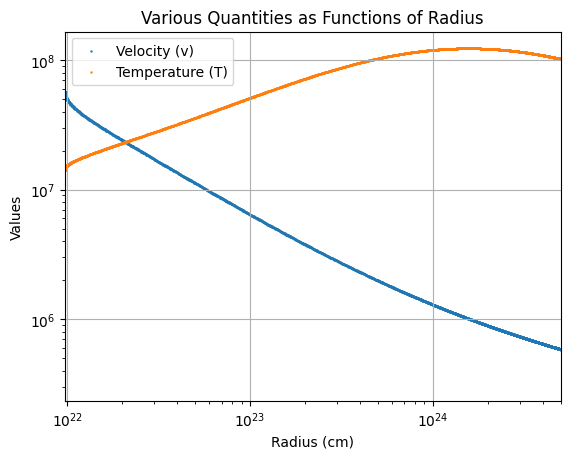

In [82]:
Tarray = np.array(Tarray)
varray = np.array(varray)
plt.scatter(ra2, varray, s=0.5, label='Velocity (v)')
plt.scatter(ra2, Tarray, s=0.5, label='Temperature (T)')
plt.xlabel('Radius (cm)')
plt.ylabel('Values')
plt.xscale('log')
plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(9.68e21, 5e24)
#plt.ylim(3e5, 3e7)
plt.grid(True)
#plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()

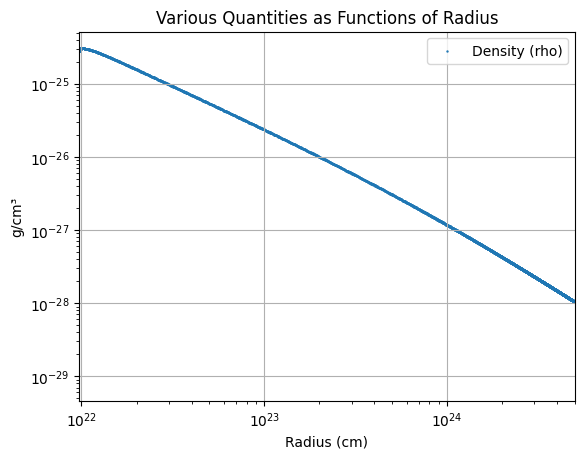

In [83]:
rhoarray = np.array(rhoarray)
plt.scatter(ra2, rhoarray, s=0.5, label='Density (rho)')
plt.xlabel('Radius (cm)')
plt.ylabel('g/cm³')
plt.xscale('log')
plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(9.68e21, 5e24)
#plt.ylim(3e5, 3e7)
plt.grid(True)
#plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()

C:\Users\Jacob\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


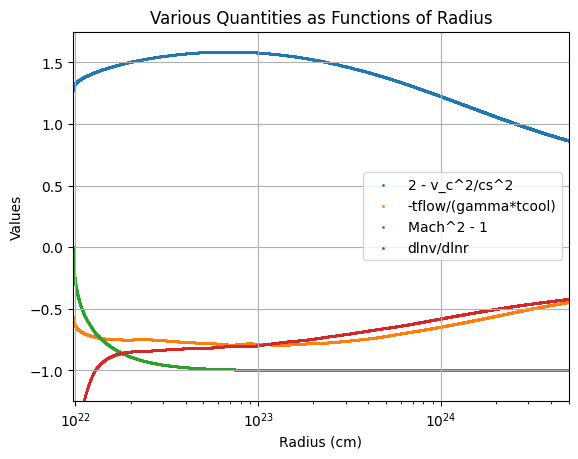

In [84]:
vccsa2 = np.array(vc_csa)
tflowtcool = np.array(tflow_tcoola)
mach21a2 = np.array(mach2a)
dlnvdlnRa1 = np.array(dlnvdlnra)
dlnTdlnRa = np.array(dlnTdlnra)
ra2 = np.array(ra2)

dlnvdlnRa2 = dlnvdlnRa1 * -2/3
tflowtcool1 = tflowtcool * (-3/5)
tflowtcool2 = tflowtcool - (4/3)

plt.scatter(ra2, vccsa2, s=1, label='2 - v_c^2/cs^2')
plt.scatter(ra2, tflowtcool1, s=1, label='-tflow/(gamma*tcool)')
plt.scatter(ra2, mach21a2, s=1, label='Mach^2 - 1')
plt.scatter(ra2, dlnvdlnRa1, s=1, label='dlnv/dlnr')
plt.xlabel('Radius (cm)')
plt.ylabel('Values')
plt.xscale('log')
#plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(9.68e21, 5e24)
plt.ylim(-1.25, 1.75)
plt.grid(True)
#plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()

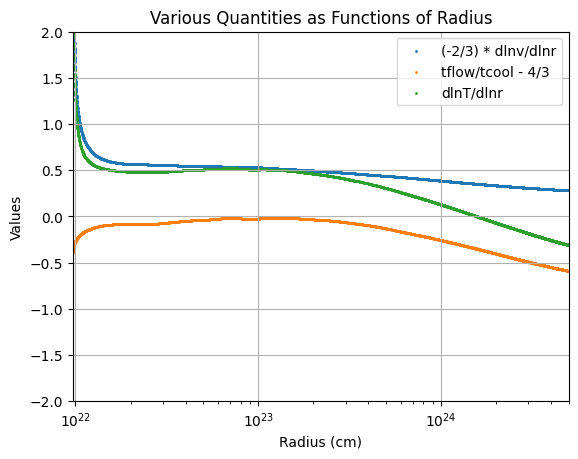

In [85]:
plt.scatter(ra2, dlnvdlnRa2, s=1, label='(-2/3) * dlnv/dlnr')
plt.scatter(ra2, tflowtcool2, s=1, label='tflow/tcool - 4/3')
plt.scatter(ra2, dlnTdlnRa, s=1, label='dlnT/dlnr')
plt.xlabel('Radius (cm)')
plt.ylabel('Values')
plt.xscale('log')
#plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(9.68e21, 5e24)
plt.ylim(-2, 2)
plt.grid(True)
#plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()

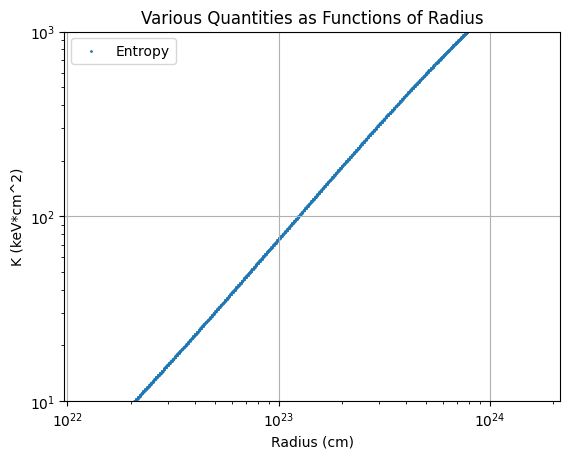

In [87]:
Karray = ((rhoarray/mp_g)**(-2/3)) * k_Bcgs * Tarray * etkv
#print(Karray)

plt.scatter(ra2, Karray, s=1, label='Entropy')
plt.xlabel('Radius (cm)')
plt.ylabel('K (keV*cm^2)')
plt.xscale('log')
plt.yscale('log')
plt.title('Various Quantities as Functions of Radius')
plt.legend()
plt.xlim(9.68e21, 2.16e24)
plt.ylim(10, 1000)
plt.grid(True)
#plt.savefig('dlnvdlnr components.png', transparent=True)
plt.show()